In [78]:
import pandas as pd
import sqlite3
from datetime import datetime, timedelta, date

def service(start_day, end_day, period, drop_holi = 0, stock_moving_avg = 1, day_shift = 0):
    '''
    각 옵션을 입력받아 해당 기간의 데이터를 DB로부터 조회하여 원하는 형태로 가공하여 리턴하는 함수
    start_day           : 조회를 시작 날짜
    end_day             : 조회 종료 날짜
    period              : 뉴스 긍부정과 주가를 이동평균 낼 기간
    drop_holi           : 주말 혹은 공휴일 뉴스를 사용할지 여부. 0 (디폴트) - 다음 영업일 주가로 채워서 사용 / 1 - 주말 및 공휴일 데이터는 drop
    stock_moving_avg    : 주가를 이동평균 낼지 여부. 1 (디폴트) - 주가 이동평균 사용 / 0 - 이동평균 사용안함
    day_shift           : 뉴스와 주가의 몇 일의 텀을 두고 분석할 지.  0(디폴트) | +x - 해당일의 뉴스와 다음날의 주가 분석 | -x - 해당일의 뉴스와 전날의 주가 분석 
    '''
    # 이동평균을 고려하여 DB에서 조회할 날짜 설정
    inq_day = (datetime.strptime(str(start_day), "%Y%m%d").date() - timedelta(days = period - 1)).strftime('%Y%m%d')
    end_day = str(end_day)

    # db 경로는 로컬에 맞게 설정해야함
    conn = sqlite3.connect("C:/Python_workspace/2jo_Final_Python/DB/samsung.db")

    # 커서 바인딩
    c = conn.cursor()

    # 뉴스데이터 조회
    query = c.execute(f"select a.id, a.date, a.code, b.senti, b.senti_proba from news_db b join news_id a on b.id = a.id where a.date BETWEEN {inq_day} and {end_day};")
    # 컬럼명 조회
    cols = [column[0] for column in query.description]
    # 데이터 프레임으로 만들기
    news_result = pd.DataFrame.from_records(data=query.fetchall(), columns=cols)

    # 커서 닫기 - 일단 주석처리함
    # conn.close()

    # 주가 데이터 조회
    # query = c.execute("select a.id, a.date, a.code, b.senti, b.senti_proba from news_db b join news_id a on b.id = a.id where a.date BETWEEN '20210111' and '20210118';")
    query = c.execute(f"select s_date, s_code, close-open from stock_db where s_date BETWEEN {inq_day} and {end_day};")
    # 컬럼명 조회
    cols = [column[0] for column in query.description]
    # 데이터 프레임으로 만들기
    stock_result = pd.DataFrame.from_records(data=query.fetchall(), columns=cols)
    stock_result.rename(columns={'s_date': 'date', 's_code': 'code', 'close-open': 'UpDown'}, inplace=True)
    
    # 주말 및 공휴일 drop 여부는 옵션에 따라; 디폴트는 드랍안함
    if drop_holi:
        # 주말이나 공휴일 등으로 주가가 빠진 날은 drop
        merge_outer_df = pd.merge(news_result,stock_result, how='outer',on='date')
        merge_outer_df = merge_outer_df.dropna(subset=['UpDown'])
    else:
        # 주말이나 공휴일 등으로 주가가 빠진 날은 다음 Business Day의 주가로 채워줌
        merge_outer_df = pd.merge(news_result,stock_result, how='outer',on='date').fillna(method='bfill')

    dateg = merge_outer_df.groupby(['date']).mean()
    dateg = dateg[['senti', 'UpDown']]
    dateg = dateg.reset_index()

    # 설정한 기간에 따라 뉴스 긍부정 이동평균
    dateg['senti_moving_avg'] = dateg['senti'].rolling(window=period).mean()

    # 주가의 이동평균은 옵션에 따라 결정; 디폴트는 이동평균 사용
    if stock_moving_avg:
        dateg['UpDown_moving_avg'] = dateg['UpDown']
    else:
        dateg['UpDown_moving_avg'] = dateg['UpDown'].rolling(window=period).mean()

    dateg = dateg[['date', 'senti_moving_avg', 'UpDown_moving_avg']]

    # 뉴스와 주가사이의 텀 설정
    dateg['UpDown_moving_avg'] = dateg['UpDown_moving_avg'].shift(day_shift)
    dateg.dropna(inplace=True)
    
    return dateg

In [91]:
# 정의한 함수 실행
result = service(20210401, 20210501, 3, drop_holi=1, stock_moving_avg=1, day_shift = 5)
result.head()

,date,senti_moving_avg,UpDown_moving_avg
5,20210406,0.133704,600.0
6,20210407,0.071204,-1000.0
7,20210408,0.160434,400.0
8,20210409,0.178953,800.0
9,20210412,0.177728,-400.0


In [92]:
# 열 정규화 하기
import pandas as pd
from sklearn import preprocessing

date_c = list(result['date'])

x = result.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
result = pd.DataFrame(x_scaled, columns=result.columns)
result['date'] = date_c
result['date'] = result['date'].astype(str)
result['date'] = pd.to_datetime(result['date'])
result.head()

,date,senti_moving_avg,UpDown_moving_avg
0,2021-04-06,0.356062,0.809524
1,2021-04-07,0.175064,0.047619
2,2021-04-08,0.433473,0.714286
3,2021-04-09,0.487102,0.904762
4,2021-04-12,0.483553,0.333333


(array([18722., 18726., 18730., 18734., 18738., 18742., 18746., 18748.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

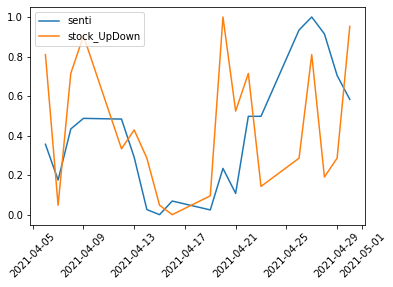

In [93]:
# 긍부정과 상관관계 그래프 도시
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ax = sns.scatterplot(data=result, x='senti_moving_avg', y='UpDown_moving_avg')
# fig, axe1 = plt.subplots()
# axe2 = axe1.twinx()
# c1 = sns.lineplot(ax = axe1, data = result, x = 'date', y = 'senti_moving_avg', color = 'red')
# c2 = sns.lineplot(ax = axe2, data = result, x = 'date', y = 'UpDown_moving_avg', color = 'blue')

plt.plot(result['date'], result['senti_moving_avg'], label = 'senti') 
plt.plot(result['date'], result['UpDown_moving_avg'], label='stock_UpDown')
plt.legend()
plt.xticks(rotation=45)

<AxesSubplot:>

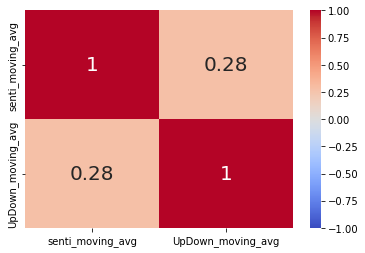

In [94]:
# 상관계수 찍어보기
pairplot = result
sns.heatmap(pairplot.corr(), vmin=-1, vmax=1, annot=True, cmap="coolwarm", annot_kws={'size' : 20})